# Lecture 11

# Aggregation and Grouping

An essential piece of analysis of large data is efficient summarization: computing aggregations like ``sum()``, ``mean()``, ``median()``, ``min()``, and ``max()``, in which a single number gives insight into the nature of a potentially large dataset.
In this section, we'll explore aggregations in Pandas, from simple operations akin to what we've seen on NumPy arrays, to more sophisticated operations based on the concept of a ``groupby``.

For convenience, we'll use the same ``display`` magic function that we've seen in previous sections:

In [1]:
import numpy as np
import pandas as pd

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Planets Data

Here we will use the Planets dataset, available via the [Seaborn package](http://seaborn.pydata.org/).
It gives information on planets that astronomers have discovered around other stars (known as *extrasolar planets* or *exoplanets* for short). The dataset originate from https://exoplanets.nasa.gov/discovery/exoplanet-catalog/
It can be downloaded with a simple Seaborn command:

In [2]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [3]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


This has some details on the 1,000+ extrasolar planets discovered up to 2014.

## Simple Aggregation in Pandas

Earlier, we explored some of the data aggregations available for NumPy arrays.
As with a one-dimensional NumPy array, for a Pandas ``Series`` the aggregates return a single value:

In [4]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [5]:
ser.sum()

2.811925491708157

In [6]:
ser.mean()

0.5623850983416314

For a ``DataFrame``, by default the aggregates return results within each column:

In [7]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [8]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

By specifying the ``axis`` argument, you can instead aggregate within each row:

In [9]:
df.mean(axis='columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

Pandas ``Series`` and ``DataFrame``s include all of the common aggregates of ``NumPy``; in addition, there is a convenience method ``describe()`` that computes several common aggregates for each column and returns the result.
Let's use this on the Planets data, for now dropping rows with missing values:

In [10]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


This can be a useful way to begin understanding the overall properties of a dataset.
For example, we see in the ``year`` column that although exoplanets were discovered as far back as 1989, half of all known expolanets were not discovered until 2009 or after.
This is largely thanks to the *Kepler* mission, which is a space-based telescope specifically designed for finding eclipsing planets around other stars.

The following table summarizes some other built-in Pandas aggregations:

| Aggregation              | Description                     |
|--------------------------|---------------------------------|
| ``count()``              | Total number of items           |
| ``first()``, ``last()``  | First and last item             |
| ``mean()``, ``median()`` | Mean and median                 |
| ``min()``, ``max()``     | Minimum and maximum             |
| ``std()``, ``var()``     | Standard deviation and variance |
| ``mad()``                | Mean absolute deviation         |
| ``prod()``               | Product of all items            |
| ``sum()``                | Sum of all items                |

These are all methods of ``DataFrame`` and ``Series`` objects.

To go deeper into the data, however, simple aggregates are often not enough.
The next level of data summarization is the ``groupby`` operation, which allows you to quickly and efficiently compute aggregates on subsets of data.

## GroupBy: Split, Apply, Combine

Simple aggregations can give you a flavor of your dataset, but often we would prefer to aggregate conditionally on some label or index: this is implemented in the so-called ``groupby`` operation.
The name "group by" comes from a command in the SQL database language, but it is perhaps more illuminative to think of it in the terms: *split, apply, combine* - https://pdfs.semanticscholar.org/00f2/4da91761a113444b6522a498cfa030a3832b.pdf

### Split, apply, combine

A canonical example of this split-apply-combine operation, where the "apply" is a summation aggregation, is illustrated in this figure:

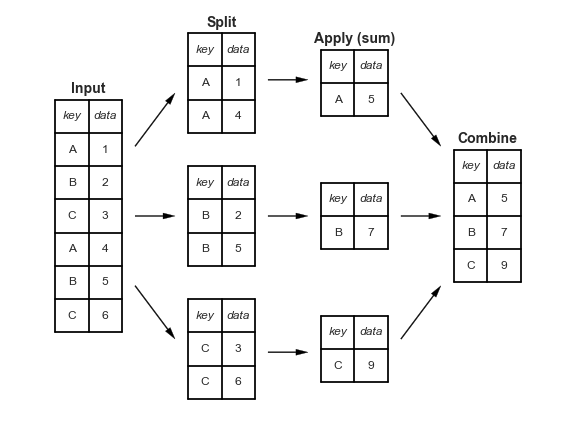

This makes clear what the ``groupby`` accomplishes:

- The *split* step involves breaking up and grouping a ``DataFrame`` depending on the value of the specified key.
- The *apply* step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
- The *combine* step merges the results of these operations into an output array.

While this could certainly be done manually using some combination of the masking, aggregation, and merging commands covered earlier, an important realization is that *the intermediate splits do not need to be explicitly instantiated*. Rather, the ``GroupBy`` can (often) do this in a single pass over the data, updating the sum, mean, count, min, or other aggregate for each group along the way.
The power of the ``GroupBy`` is that it abstracts away these steps: the user need not think about *how* the computation is done under the hood, but rather thinks about the *operation as a whole*.

As a concrete example, let's take a look at using Pandas for the computation shown in this diagram.
We'll start by creating the input ``DataFrame``:

In [11]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


The most basic split-apply-combine operation can be computed with the ``groupby()`` method of ``DataFrame``s, passing the name of the desired key column:

In [12]:
df.groupby('key')

Notice that what is returned is not a set of ``DataFrame``s, but a ``DataFrameGroupBy`` object.
This object is where the magic is: you can think of it as a special view of the ``DataFrame``, which is poised to dig into the groups but does no actual computation until the aggregation is applied.
This "lazy evaluation" approach means that common aggregates can be implemented very efficiently in a way that is almost transparent to the user.

To produce a result, we can apply an aggregate to this ``DataFrameGroupBy`` object, which will perform the appropriate apply/combine steps to produce the desired result:

In [13]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


The ``sum()`` method is just one possibility here; you can apply virtually any common Pandas or NumPy aggregation function, as well as virtually any valid ``DataFrame`` operation, as we will see in the following discussion.

### The GroupBy object

The ``GroupBy`` object is a very flexible abstraction.
In many ways, you can simply treat it as if it's a collection of ``DataFrame``s, and it does the difficult things under the hood. Let's see some examples using the Planets data.

Perhaps the most important operations made available by a ``GroupBy`` are *aggregate*, *filter*, *transform*, and *apply*.
Let's introduce some of the other functionality that can be used with the basic ``GroupBy`` operation.

#### Column indexing

The ``GroupBy`` object supports column indexing in the same way as the ``DataFrame``, and returns a modified ``GroupBy`` object.
For example:

In [14]:
planets.groupby('method')

In [15]:
planets.groupby('method')['orbital_period']

Here we've selected a particular ``Series`` group from the original ``DataFrame`` group by reference to its column name.
As with the ``GroupBy`` object, no computation is done until we call some aggregate on the object:

In [16]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

This gives an idea of the general scale of orbital periods (in days) that each method is sensitive to.

#### Iteration over groups

The ``GroupBy`` object supports direct iteration over the groups, returning each group as a ``Series`` or ``DataFrame``:

In [17]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape)) 
    # in shape first figure is the number of entities in group
    # the second one is the number of columns

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


In [18]:
for (method, group) in planets.groupby('method'):
    print(group)

         method  number  orbital_period  mass  distance  year
113  Astrometry       1          246.36   NaN     20.77  2013
537  Astrometry       1         1016.00   NaN     14.98  2010
                       method  number  orbital_period  mass  distance  year
32  Eclipse Timing Variations       1        10220.00  6.05       NaN  2009
37  Eclipse Timing Variations       2         5767.00   NaN    130.72  2008
38  Eclipse Timing Variations       2         3321.00   NaN    130.72  2008
39  Eclipse Timing Variations       2         5573.55   NaN    500.00  2010
40  Eclipse Timing Variations       2         2883.50   NaN    500.00  2010
41  Eclipse Timing Variations       1         2900.00   NaN       NaN  2011
42  Eclipse Timing Variations       1         4343.50  4.20       NaN  2012
43  Eclipse Timing Variations       2         5840.00   NaN       NaN  2011
44  Eclipse Timing Variations       2         1916.25   NaN       NaN  2011
       method  number  orbital_period  mass  distance 

This can be useful for doing certain things manually, though it is often much faster to use the built-in ``apply`` functionality.

#### Dispatch methods

Through some Python class magic, any method not explicitly implemented by the ``GroupBy`` object will be passed through and called on the groups, whether they are ``DataFrame`` or ``Series`` objects.
For example, you can use the ``describe()`` method of ``DataFrame``s to perform a set of aggregations that describe each group in the data:

In [19]:
planets.groupby('method')['year'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
Astrometry,2.0,2011.500000,2.121320,2010.0,2010.75,2011.5,2012.25,2013.0
Eclipse Timing Variations,9.0,2010.000000,1.414214,2008.0,2009.00,2010.0,2011.00,2012.0
Imaging,38.0,2009.131579,2.781901,2004.0,2008.00,2009.0,2011.00,2013.0
Microlensing,23.0,2009.782609,2.859697,2004.0,2008.00,2010.0,2012.00,2013.0
Orbital Brightness Modulation,3.0,2011.666667,1.154701,2011.0,2011.00,2011.0,2012.00,2013.0
Pulsar Timing,5.0,1998.400000,8.384510,1992.0,1992.00,1994.0,2003.00,2011.0
Pulsation Timing Variations,1.0,2007.000000,NaN,2007.0,2007.00,2007.0,2007.00,2007.0
Radial Velocity,553.0,2007.518987,4.249052,1989.0,2005.00,2009.0,2011.00,2014.0
Transit,397.0,2011.236776,2.077867,2002.0,2010.00,2012.0,2013.00,2014.0


Looking at this table helps us to better understand the data: for example, the vast majority of planets have been discovered by the Radial Velocity and Transit methods, though the latter only became common (due to new, more accurate telescopes) relatively recently.
The newest methods seem to be Transit Timing Variation and Orbital Brightness Modulation, which were not used to discover a new planet until 2011.

This is just one example of the utility of dispatch methods.
Notice that they are applied *to each individual group*, and the results are then combined within ``GroupBy`` and returned.
Again, any valid ``DataFrame``/``Series`` method can be used on the corresponding ``GroupBy`` object, which allows for some very flexible and powerful operations!

### Aggregate, filter, transform, apply

The preceding discussion focused on aggregation for the combine operation, but there are more options available.
In particular, ``GroupBy`` objects have ``aggregate()``, ``filter()``, ``transform()``, and ``apply()`` methods that efficiently implement a variety of useful operations before combining the grouped data.

For the purpose of the following subsections, we'll use this ``DataFrame``:

In [20]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


#### Aggregation

We're now familiar with ``GroupBy`` aggregations with ``sum()``, ``median()``, and the like, but the ``aggregate()`` method allows for even more flexibility.
It can take a string, a function, or a list thereof, and compute all the aggregates at once.
Here is a quick example combining all these:

In [21]:
df.groupby('key').aggregate(['min', np.median, 'max'])

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

Another useful pattern is to pass a dictionary mapping column names to operations to be applied on that column:

In [22]:
df.groupby('key').agg({'data1': 'min',
                             'data2': 'max'})

,data1,data2
key,,
A,0,5
B,1,7
C,2,9


#### Filtering

A filtering operation allows you to drop data based on the group properties.
For example, we might want to keep all groups in which the standard deviation is larger than some critical value:

In [23]:
def filter_func(x):
    return x['data2'].std() > 4

display('df', "df.groupby('key').std()", "df.groupby('key').filter(filter_func)")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9

The filter function should return a Boolean value specifying whether the group passes the filtering. Here because group A does not have a standard deviation greater than 4, it is dropped from the result.

#### Transformation

While aggregation must return a reduced version of the data, transformation can return some transformed version of the full data to recombine.
For such a transformation, the output is the same shape as the input.
A common example is to center the data by subtracting the group-wise mean:

In [24]:
df.groupby('key').transform(lambda x: x - x.mean())

,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,-3.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,3.0


#### The apply() method

The ``apply()`` method lets you apply an arbitrary function to the group results.
The function should take a ``DataFrame``, and return either a Pandas object (e.g., ``DataFrame``, ``Series``) or a scalar; the combine operation will be tailored to the type of output returned.

For example, here is an ``apply()`` that normalizes the first column by the sum of the second:

In [25]:
def norm_by_data2(x):
    # x is a DataFrame of group values
    x['data1'] /= x['data2'].sum()
    return x

display('df', "df.groupby('key').apply(norm_by_data2)")

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9
,key,data1,data2
0,A,0.000000,5
1,B,0.142857,0
2,C,0.166667,3


``apply()`` within a ``GroupBy`` is quite flexible: the only criterion is that the function takes a ``DataFrame`` and returns a Pandas object or scalar.

### Difference between ``apply`` and ``transform``

In [26]:
df.groupby('key').apply(lambda x: x - x.mean())

,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,-3.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,3.0


In [27]:
try:
    df.groupby('key').transform(norm_by_data2)
except Exception as e:
    print (type(e))
    print(e)


<class 'KeyError'>
'data1'


There are two major differences between the ``transform`` and ``apply`` groupby methods.

* Input:
    - ``apply`` implicitly passes all the columns for each group as a ``DataFrame`` to the custom function.
    - while ``transform`` passes each column for each group individually as a ``Series`` to the custom function.
* Output:
    - The custom function passed to ``apply`` can return a scalar, or a Series or ``DataFrame`` (or numpy array or even list).
    - The custom function passed to ``transform`` must return a sequence (a one dimensional ``Series``, array or list) the **same length** as the group.
    
So, ``transform`` works on just one ``Series`` at a time and ``apply`` works on the entire DataFrame at once.

### Specifying the split key

In the simple examples presented before, we split the ``DataFrame`` on a single column name.
This is just one of many options by which the groups can be defined, and we'll go through some other options for group specification here.

#### A list, array, series, or index providing the grouping keys

The key can be any series or list with a length matching that of the ``DataFrame``. For example:

In [28]:
L = [0, 1, 0, 1, 2, 0]
display('df', 'df.groupby(L).sum()')

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(L).sum()
   data1  data2
0      7     17
1      4      3
2      4      7

This means there's another, more verbose way of accomplishing the ``df.groupby('key')`` from before:

In [29]:
display('df', "df.groupby(df['key']).sum()")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(df['key']).sum()
     data1  data2
key              
A        3      8
B        5      7
C        7     12

#### A dictionary or series mapping index to group

Another method is to provide a dictionary that maps index values to the group keys:

In [30]:
df2 = df.set_index('key')
mapping = {'A': 'cats', 'B': 'dogs', 'C': 'dogs'}
display('df2', 'df2.groupby(mapping).sum()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
cats,3,8
dogs,12,19


To group by index - use ``level`` keyword

In [31]:
display('df2', 'df2.groupby(level=0).mean()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
key,,
A,1.5,4.0


#### Any Python function

Similar to mapping, you can pass any Python function that will input the index value and output the group:

In [32]:
display('df2', 'df2.groupby(str,level=0).mean()') # level = 0 is default 

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
key,,
A,1.5,4.0


In [33]:
display('df2', 'df2.groupby(str.lower).mean()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
a,1.5,4.0
b,2.5,3.5


#### A list of valid keys

Further, any of the preceding key choices can be combined to group on a multi-index:

In [34]:
df2.groupby([str.lower, mapping]).mean()

,,data1,data2
a,cats,1.5,4.0
b,dogs,2.5,3.5
c,dogs,3.5,6.0


### Grouping example

As an example of this, in a couple lines of Python code we can put all these together and count discovered planets by method and by decade:

In [35]:
decade = 10 * (planets['year'] // 10)
decade

0       2000
1       2000
2       2010
3       2000
4       2000
        ... 
1030    2000
1031    2000
1032    2000
1033    2000
1034    2000
Name: year, Length: 1035, dtype: int64

In [36]:
decade = decade.astype(str) + 's'
decade

0       2000s
1       2000s
2       2010s
3       2000s
4       2000s
        ...  
1030    2000s
1031    2000s
1032    2000s
1033    2000s
1034    2000s
Name: year, Length: 1035, dtype: object

In [37]:
decade.name = 'decade'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0


This shows the power of combining many of the operations we've discussed up to this point when looking at realistic datasets.
We immediately gain a coarse understanding of when and how planets have been discovered over the past several decades!

In [38]:
planets.groupby(['method'])['number'].sum()

method
Astrometry                         2
Eclipse Timing Variations         15
Imaging                           50
Microlensing                      27
Orbital Brightness Modulation      5
Pulsar Timing                     11
Pulsation Timing Variations        1
Radial Velocity                  952
Transit                          776
Transit Timing Variations          9
Name: number, dtype: int64

In [39]:
for group, frame in planets.groupby(['method']):
    sum_ = np.sum(frame['number'])
    
# You'll notice there are two values we set here. groupby() returns a tuple, where the first value is the
# value of the key we were trying to group by, in this case a method, and the second one is
# projected dataframe that was found for that group
       
    # Print the results
    
    print('Using ' + group + ' method '
          ' we have ' + str(sum_) + ' planet(s)')

Using Astrometry method  we have 2 planet(s)
Using Eclipse Timing Variations method  we have 15 planet(s)
Using Imaging method  we have 50 planet(s)
Using Microlensing method  we have 27 planet(s)
Using Orbital Brightness Modulation method  we have 5 planet(s)
Using Pulsar Timing method  we have 11 planet(s)
Using Pulsation Timing Variations method  we have 1 planet(s)
Using Radial Velocity method  we have 952 planet(s)
Using Transit method  we have 776 planet(s)
Using Transit Timing Variations method  we have 9 planet(s)


In [40]:
planets.groupby(['method', decade])['number'].sum()

method                         decade
Astrometry                     2010s       2
Eclipse Timing Variations      2000s       5
                               2010s      10
Imaging                        2000s      29
                               2010s      21
Microlensing                   2000s      12
                               2010s      15
Orbital Brightness Modulation  2010s       5
Pulsar Timing                  1990s       9
                               2000s       1
                               2010s       1
Pulsation Timing Variations    2000s       1
Radial Velocity                1980s       1
                               1990s      52
                               2000s     475
                               2010s     424
Transit                        2000s      64
                               2010s     712
Transit Timing Variations      2010s       9
Name: number, dtype: int64

Let's see more complicated example

In [56]:
for group, frame in planets.groupby(['method', decade]):
    sum_ = np.sum(frame['number'])
  
    print('Using ' + str(group[0]) + ' method in '+ str(group[1]) +
          ' decade we have ' + str(sum_) + ' planet(s)')

Using Astrometry method in 2010s decade we have 2 planet(s)
Using Eclipse Timing Variations method in 2000s decade we have 5 planet(s)
Using Eclipse Timing Variations method in 2010s decade we have 10 planet(s)
Using Imaging method in 2000s decade we have 29 planet(s)
Using Imaging method in 2010s decade we have 21 planet(s)
Using Microlensing method in 2000s decade we have 12 planet(s)
Using Microlensing method in 2010s decade we have 15 planet(s)
Using Orbital Brightness Modulation method in 2010s decade we have 5 planet(s)
Using Pulsar Timing method in 1990s decade we have 9 planet(s)
Using Pulsar Timing method in 2000s decade we have 1 planet(s)
Using Pulsar Timing method in 2010s decade we have 1 planet(s)
Using Pulsation Timing Variations method in 2000s decade we have 1 planet(s)
Using Radial Velocity method in 1980s decade we have 1 planet(s)
Using Radial Velocity method in 1990s decade we have 52 planet(s)
Using Radial Velocity method in 2000s decade we have 475 planet(s)
Usin

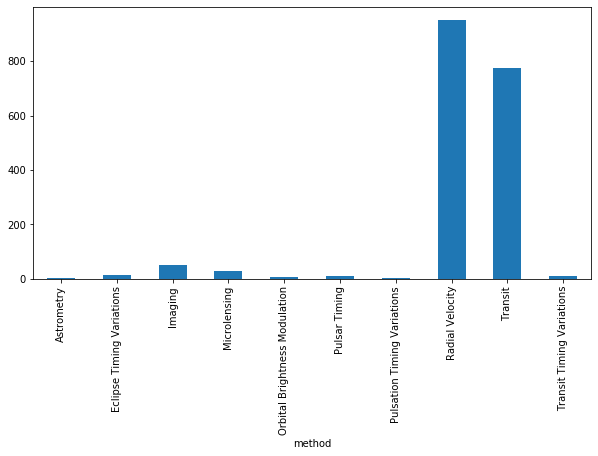

In [42]:
planets.groupby(['method'])['number'].sum().fillna(0).plot(kind='bar',figsize=(10,5))

# Pivot Tables

We have seen how the ``GroupBy`` abstraction lets us explore relationships within a dataset.
A *pivot table* is a similar operation that is commonly seen in spreadsheets and other programs that operate on tabular data.
The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data.
The difference between pivot tables and ``GroupBy`` can sometimes cause confusion; it helps to think of pivot tables as essentially a *multidimensional* version of ``GroupBy`` aggregation.
That is, you split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

## Motivating Pivot Tables

For the examples in this section, we'll use the database of passengers on the *Titanic*, available through the Seaborn library:

In [43]:
titanic = sns.load_dataset('titanic')


In [44]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


This contains a wealth of information on each passenger of that ill-fated voyage, including gender, age, class, fare paid, and much more.

## Pivot Tables by Hand

To start learning more about this data, we might begin by grouping according to gender, survival status, or some combination thereof.
Let's apply a ``GroupBy`` operation – for example, let's look at survival rate by gender:

In [45]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


This immediately gives us some insight: overall, three of every four females on board survived, while only one in five males survived!

This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class.
Using the vocabulary of ``GroupBy``, we might proceed using something like this:
we *group by* class and gender, *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and then *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

In [46]:
titanic.groupby(['sex', 'class'])['survived'].mean().unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This gives us a better idea of how both gender and class affected survival.
While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use.
This two-dimensional ``GroupBy`` is common enough that Pandas includes a convenience routine, ``pivot_table``, which succinctly handles this type of multi-dimensional aggregation.

## Pivot Table Syntax

Here is the equivalent to the preceding operation using the ``pivot_table`` method of ``DataFrame``s:

In [47]:
titanic.pivot_table(values='survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This is eminently more readable than the ``groupby`` approach, and produces the same result.
As you might expect of an early 20th-century transatlantic cruise, the survival gradient favors both women and higher classes.
First-class women survived with near certainty, while only one in ten third-class men survived.

### Multi-level pivot tables

Just as in the ``GroupBy``, the grouping in pivot tables can be specified with multiple levels, and via a number of options.
For example, we might be interested in looking at age as a third dimension.
We'll bin the age using the ``pd.cut`` function:

In [48]:
age = pd.cut(titanic['age'], [0, 18, 80]) # put age into two bins (0,18] and (18,80]
age

0      (18.0, 80.0]
1      (18.0, 80.0]
2      (18.0, 80.0]
3      (18.0, 80.0]
4      (18.0, 80.0]
           ...     
886    (18.0, 80.0]
887    (18.0, 80.0]
888             NaN
889    (18.0, 80.0]
890    (18.0, 80.0]
Name: age, Length: 891, dtype: category
Categories (2, interval[int64]): [(0, 18] < (18, 80]]

In [49]:
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

We can apply the same strategy when working with the columns as well; let's add info on the fare paid using ``pd.qcut`` to automatically compute quantiles:

In [50]:
fare = pd.qcut(titanic['fare'], 2)
fare


0       (-0.001, 14.454]
1      (14.454, 512.329]
2       (-0.001, 14.454]
3      (14.454, 512.329]
4       (-0.001, 14.454]
             ...        
886     (-0.001, 14.454]
887    (14.454, 512.329]
888    (14.454, 512.329]
889    (14.454, 512.329]
890     (-0.001, 14.454]
Name: fare, Length: 891, dtype: category
Categories (2, interval[float64]): [(-0.001, 14.454] < (14.454, 512.329]]

In [51]:
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

The result is a four-dimensional aggregation with hierarchical indices shown in a grid demonstrating the relationship between the values.

### Additional pivot table options

The full call signature of the ``pivot_table`` method of ``DataFrame``s is as follows:

```python
# call signature as of Pandas 0.18
DataFrame.pivot_table(values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

We've already seen examples of the first three arguments; here we'll take a quick look at the remaining ones.
Two of the options, ``fill_value`` and ``dropna``, have to do with missing data and are fairly straightforward; we will not show examples of them here.

The ``aggfunc`` keyword controls what type of aggregation is applied, which is a mean by default.
As in the GroupBy, the aggregation specification can be a string representing one of several common choices (e.g., ``'sum'``, ``'mean'``, ``'count'``, ``'min'``, ``'max'``, etc.) or a function that implements an aggregation (e.g., ``np.sum()``, ``min()``, ``sum()``, etc.).
Additionally, it can be specified as a dictionary mapping a column to any of the above desired options:

In [52]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Notice also here that we've omitted the ``values`` keyword; when specifying a mapping for ``aggfunc``, this is determined automatically.

At times it's useful to compute totals along each grouping.
This can be done via the ``margins`` keyword:

In [53]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


Here this automatically gives us information about the class-agnostic survival rate by gender, the gender-agnostic survival rate by class, and the overall survival rate of 38%.
The margin label can be specified with the ``margins_name`` keyword, which defaults to ``"All"``.

In [54]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True, margins_name= 'Totals')

class,First,Second,Third,Totals
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
Totals,0.629630,0.472826,0.242363,0.383838
